In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import os
import numpy as np
import itertools

In [2]:
#Covid Tracking project API
#this works interimittentently presumably due to load on their servers
#@todo wrap function with a retry decorator

daily = pd.read_json("https://covidtracking.com/api/states/daily", orient='records')
daily

,date,state,positive,negative,pending,hospitalized,death,total,dateChecked,totalTestResults,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200325,AK,42.0,1649.0,NaN,1.0,1.0,1691,2020-03-25T20:00:00Z,1691,1.0,1.0,663.0,6.0,669.0
1,20200325,AL,283.0,2529.0,NaN,NaN,0.0,2812,2020-03-25T20:00:00Z,2812,0.0,0.0,423.0,68.0,491.0
2,20200325,AR,280.0,1437.0,0.0,22.0,2.0,1717,2020-03-25T20:00:00Z,1717,2.0,0.0,490.0,62.0,552.0
3,20200325,AS,0.0,NaN,NaN,NaN,0.0,0,2020-03-25T20:00:00Z,0,0.0,0.0,0.0,0.0,0.0
4,20200325,AZ,450.0,323.0,53.0,8.0,6.0,826,2020-03-25T20:00:00Z,773,1.0,0.0,10.0,93.0,103.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1088,20200304,OR,3.0,29.0,18.0,NaN,NaN,50,2020-03-04T21:00:00Z,32,NaN,NaN,NaN,NaN,NaN
1089,20200304,SC,0.0,5.0,0.0,NaN,NaN,5,2020-03-04T21:00:00Z,5,NaN,NaN,NaN,NaN,NaN
1090,20200304,TX,1.0,NaN,NaN,NaN,NaN,1,2020-03-04T21:00:00Z,1,NaN,NaN,NaN,NaN,NaN
1091,20200304,WA,39.0,NaN,NaN,NaN,NaN,39,2020-03-04T21:00:00Z,39,NaN,NaN,NaN,NaN,NaN


In [3]:
states = pd.read_json("https://covidtracking.com/api/states", orient='records')

In [4]:
states.set_index("state", drop=True).loc["NY"]

positive                               30811
positiveScore                              1
negativeScore                              1
negativeRegularScore                       0
commercialScore                            1
grade                                      B
score                                      3
negative                               72668
pending                                  NaN
hospitalized                            3805
death                                    285
total                                 103479
lastUpdateEt                      3/25 11:45
checkTimeEt                       3/25 13:12
dateModified            2020-03-25T15:45:00Z
dateChecked             2020-03-25T17:12:00Z
Name: NY, dtype: object

In [5]:
population = pd.read_csv("https://raw.githubusercontent.com/datasets/population/master/data/population.csv")

In [6]:
population.loc[population["Country Name"].str.contains("Italy")].tail(1)

,Country Name,Country Code,Year,Value
8088,Italy,ITA,2016,60600590.0


In [7]:
daily.date = daily.date.astype("str").apply(pd.to_datetime).dt.date

In [8]:
daily = daily.set_index(["state","date"], drop=True).sort_index()

In [9]:
daily_test_rate = (daily['total']-daily["total"].shift(1))
daily_test_rate.name = "daily_test"
daily = pd.concat([daily, daily_test_rate], axis=1)

In [10]:
daily

positive  negative  pending  hospitalized  death  total  \
state date                                                                  
AK    2020-03-06       0.0       8.0      1.0           NaN    NaN      9   
      2020-03-07       0.0      12.0      2.0           NaN    NaN     14   
      2020-03-08       0.0      14.0      6.0           NaN    NaN     20   
      2020-03-09       0.0      23.0      9.0           NaN    NaN     32   
      2020-03-10       0.0      23.0      9.0           NaN    NaN     32   
...                    ...       ...      ...           ...    ...    ...   
WY    2020-03-21      23.0     438.0      NaN           NaN    NaN    461   
      2020-03-22      24.0     438.0      NaN           NaN    NaN    462   
      2020-03-23      26.0     592.0      NaN           NaN    NaN    618   
      2020-03-24      29.0     710.0      NaN           NaN    NaN    739   
      2020-03-25      44.0     954.0      NaN           NaN    NaN    998   

                           dateChecked  totalTestResults  deathIncrease  \
state date                                                                
AK    2020-03-06  2020-03-06T21:00:00Z                 8            NaN   
      2020-03-07  2020-03-07T21:00:00Z                12            0.0   
      2020-03-08  2020-03-08T20:00:00Z                14            0.0   
      2020-03-09  2020-03-09T20:00:00Z                23            0.0   
      2020-03-10  2020-03-10T20:00:00Z                23            0.0   
...                                ...               ...            ...   
WY    2020-03-21  2020-03-21T20:00:00Z               461            0.0   
      2020-03-22  2020-03-22T20:00:00Z               462            0.0   
      2020-03-23  2020-03-23T20:00:00Z               618            0.0   
      2020-03-24  2020-03-24T20:00:00Z               739            0.0   
      2020-03-25  2020-03-25T20:00:00Z               998            0.0   

                  hospitalizedIncrease  negativeIncrease  positiveIncrease  \
state date                                                                   
AK    2020-03-06                   NaN               NaN               NaN   
      2020-03-07                   0.0               4.0               0.0   
      2020-03-08                   0.0               2.0               0.0   
      2020-03-09                   0.0               9.0               0.0   
      2020-03-10                   0.0               0.0               0.0   
...                                ...               ...               ...   
WY    2020-03-21                   0.0             107.0               4.0   
      2020-03-22                   0.0               0.0               1.0   
      2020-03-23                   0.0             154.0               2.0   
      2020-03-24                   0.0             118.0               3.0   
      2020-03-25                   0.0             244.0              15.0   

                  totalTestResultsIncrease  daily_test  
state date                                              
AK    2020-03-06                       NaN         NaN  
      2020-03-07                       4.0         5.0  
      2020-03-08                       2.0         6.0  
      2020-03-09                       9.0        12.0  
      2020-03-10                       0.0         0.0  
...                                    ...         ...  
WY    2020-03-21                     111.0       111.0  
      2020-03-22                       1.0         1.0  
      2020-03-23                     156.0       156.0  
      2020-03-24                     121.0       121.0  
      2020-03-25                     259.0       259.0  

[1093 rows x 14 columns]

In [11]:
daily_last_update = daily.index.get_level_values(1).max().date().strftime("%Y-%m-%d")

In [12]:
# need to develop a "days since tests scaled" index using either daily rates or use worldindata upper half pop adjusted data
# this file must be manually updated from this page:  https://ourworldindata.org/covid-testing  (per million data)
file = "tests-vs-confirmed-cases-covid-19-per-million.csv"
folder = "c:/users/lee/downloads"
tests_world = pd.read_csv(os.path.join(folder, file))

In [13]:
tests_world_sum = tests_world.dropna(subset=["Total COVID-19 tests per million people", \
                           "Total confirmed cases of COVID-19 per million people (cases per million)"]).\
        groupby("Entity").last()
cols = list(tests_world_sum.columns)
new_cols = ["tests_per_M", "cases_per_M"]
cols = cols[0:2]+ new_cols
tests_world_sum.columns = cols

In [14]:
world_tests_cum_median = tests_world_sum['tests_per_M'].describe()["50%"]
world_tests_cum_median

#use this as benchmark for "scale" testing

602.4000000000001

In [15]:
tests_world_sum

,Code,Year,tests_per_M,cases_per_M
Entity,,,,
Armenia,ARM,57,276.7,26.322592
Australia,AUS,59,4473.4,27.804051
Austria,AUT,59,1777.8,243.826612
Bahrain,BHR,59,10982.1,158.088086
Belarus,BLR,55,1699.3,2.857348
Belgium,BEL,57,1580.0,107.251181
Brazil,BRA,52,13.7,0.362252
Canada,CAN,59,3389.7,22.415253
Colombia,COL,59,81.7,2.515581


In [16]:
cols

['Code', 'Year', 'tests_per_M', 'cases_per_M']

In [17]:
pop = pd.read_csv("http://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv?#")

In [18]:
pop

,SUMLEV,REGION,DIVISION,STATE,NAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,...,RDOMESTICMIG2019,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019
0,10,0,0,0,United States,308745538,308758105,309321666,311556874,313830990,...,0.000000,2.493773,2.682083,2.636187,2.921500,3.260435,3.252788,2.871957,2.153911,1.818059
1,20,1,0,0,Northeast Region,55317240,55318443,55380134,55604223,55775216,...,-5.254530,0.887909,-0.038355,-0.469783,-0.986097,-2.061965,-2.490484,-1.837048,-2.134447,-2.859713
2,20,2,0,0,Midwest Region,66927001,66929725,66974416,67157800,67336743,...,-2.365881,-0.963930,-0.973943,-0.006924,-0.762969,-1.388437,-1.241784,-0.557370,-0.922755,-1.111173
3,20,3,0,0,South Region,114555744,114563030,114866680,116006522,117241208,...,3.261349,5.130513,5.850458,5.292073,6.161501,7.277358,7.150074,6.198168,5.225519,5.203720
4,20,4,0,0,West Region,71945553,71946907,72100436,72788329,73477823,...,0.614245,2.723344,3.062896,3.162262,4.026429,4.987285,5.261078,4.021194,3.044951,2.312083
5,40,3,6,1,Alabama,4779736,4780125,4785437,4799069,4815588,...,1.917501,0.578434,1.186314,1.522549,0.563489,0.626357,0.745172,1.090366,1.773786,2.483744
6,40,4,9,2,Alaska,710231,710249,713910,722128,730443,...,-12.929847,0.587728,1.416798,-0.955359,-11.460949,-7.997118,-3.897349,-10.992765,-13.859140,-12.031221
7,40,4,8,4,Arizona,6392017,6392288,6407172,6472643,6554978,...,12.609078,4.278167,6.899802,6.376679,9.168478,9.597577,11.964782,10.878879,12.962934,13.687161
8,40,3,7,5,Arkansas,2915918,2916031,2921964,2940667,2952164,...,0.834503,3.294766,0.827785,0.057853,-0.091449,1.075446,1.486269,2.009593,0.958896,0.923429
9,40,4,9,6,California,37253956,37254519,37319502,37638369,37948800,...,-5.151429,1.276797,1.495016,1.649031,2.203551,1.984957,0.500044,-0.629909,-2.130954,-3.276681


In [19]:
key_cols = ['STATE', 'NAME', 'POPESTIMATE2019']
pop_19 = pop[key_cols].set_index(["STATE", "NAME"], drop=True)
pop_19

POPESTIMATE2019
STATE NAME                                 
0     United States               328239523
      Northeast Region             55982803
      Midwest Region               68329004
      South Region                125580448
      West Region                  78347268
1     Alabama                       4903185
2     Alaska                         731545
4     Arizona                       7278717
5     Arkansas                      3017804
6     California                   39512223
8     Colorado                      5758736
9     Connecticut                   3565287
10    Delaware                       973764
11    District of Columbia           705749
12    Florida                      21477737
13    Georgia                      10617423
15    Hawaii                        1415872
16    Idaho                         1787065
17    Illinois                     12671821
18    Indiana                       6732219
19    Iowa                          3155070
20    Kansas                        2913314
21    Kentucky                      4467673
22    Louisiana                     4648794
23    Maine                         1344212
24    Maryland                      6045680
25    Massachusetts                 6892503
26    Michigan                      9986857
27    Minnesota                     5639632
28    Mississippi                   2976149
29    Missouri                      6137428
30    Montana                       1068778
31    Nebraska                      1934408
32    Nevada                        3080156
33    New Hampshire                 1359711
34    New Jersey                    8882190
35    New Mexico                    2096829
36    New York                     19453561
37    North Carolina               10488084
38    North Dakota                   762062
39    Ohio                         11689100
40    Oklahoma                      3956971
41    Oregon                        4217737
42    Pennsylvania                 12801989
44    Rhode Island                  1059361
45    South Carolina                5148714
46    South Dakota                   884659
47    Tennessee                     6829174
48    Texas                        28995881
49    Utah                          3205958
50    Vermont                        623989
51    Virginia                      8535519
53    Washington                    7614893
54    West Virginia                 1792147
55    Wisconsin                     5822434
56    Wyoming                        578759
72    Puerto Rico                   3193694

In [20]:
states_abbrev = pd.read_json("https://gist.githubusercontent.com/mshafrir/2646763/raw/8b0dbb93521f5d6889502305335104218454c2bf/states_titlecase.json")

In [21]:
states_abbrev

,name,abbreviation
0,Alabama,AL
1,Alaska,AK
2,American Samoa,AS
3,Arizona,AZ
4,Arkansas,AR
5,California,CA
6,Colorado,CO
7,Connecticut,CT
8,Delaware,DE
9,District Of Columbia,DC


In [22]:
pop_19 = pop_19.reset_index(0).join(states_abbrev.set_index('name')).set_index("abbreviation")
pop_19

,STATE,POPESTIMATE2019
abbreviation,,
NaN,0,328239523
NaN,0,55982803
NaN,0,68329004
NaN,0,125580448
NaN,0,78347268
AL,1,4903185
AK,2,731545
AZ,4,7278717
AR,5,3017804


In [23]:
pop_19 = pop_19.loc[pop_19.index.dropna()]
pop_19

,STATE,POPESTIMATE2019
abbreviation,,
AL,1,4903185
AK,2,731545
AZ,4,7278717
AR,5,3017804
CA,6,39512223
CO,8,5758736
CT,9,3565287
DE,10,973764
FL,12,21477737


In [24]:
daily = daily.reset_index().join(pop_19, on="state", how = 'inner').set_index(['state', 'date'], drop=True).sort_index()
daily

positive  negative  pending  hospitalized  death  total  \
state date                                                                  
AK    2020-03-06       0.0       8.0      1.0           NaN    NaN      9   
      2020-03-07       0.0      12.0      2.0           NaN    NaN     14   
      2020-03-08       0.0      14.0      6.0           NaN    NaN     20   
      2020-03-09       0.0      23.0      9.0           NaN    NaN     32   
      2020-03-10       0.0      23.0      9.0           NaN    NaN     32   
...                    ...       ...      ...           ...    ...    ...   
WY    2020-03-21      23.0     438.0      NaN           NaN    NaN    461   
      2020-03-22      24.0     438.0      NaN           NaN    NaN    462   
      2020-03-23      26.0     592.0      NaN           NaN    NaN    618   
      2020-03-24      29.0     710.0      NaN           NaN    NaN    739   
      2020-03-25      44.0     954.0      NaN           NaN    NaN    998   

                           dateChecked  totalTestResults  deathIncrease  \
state date                                                                
AK    2020-03-06  2020-03-06T21:00:00Z                 8            NaN   
      2020-03-07  2020-03-07T21:00:00Z                12            0.0   
      2020-03-08  2020-03-08T20:00:00Z                14            0.0   
      2020-03-09  2020-03-09T20:00:00Z                23            0.0   
      2020-03-10  2020-03-10T20:00:00Z                23            0.0   
...                                ...               ...            ...   
WY    2020-03-21  2020-03-21T20:00:00Z               461            0.0   
      2020-03-22  2020-03-22T20:00:00Z               462            0.0   
      2020-03-23  2020-03-23T20:00:00Z               618            0.0   
      2020-03-24  2020-03-24T20:00:00Z               739            0.0   
      2020-03-25  2020-03-25T20:00:00Z               998            0.0   

                  hospitalizedIncrease  negativeIncrease  positiveIncrease  \
state date                                                                   
AK    2020-03-06                   NaN               NaN               NaN   
      2020-03-07                   0.0               4.0               0.0   
      2020-03-08                   0.0               2.0               0.0   
      2020-03-09                   0.0               9.0               0.0   
      2020-03-10                   0.0               0.0               0.0   
...                                ...               ...               ...   
WY    2020-03-21                   0.0             107.0               4.0   
      2020-03-22                   0.0               0.0               1.0   
      2020-03-23                   0.0             154.0               2.0   
      2020-03-24                   0.0             118.0               3.0   
      2020-03-25                   0.0             244.0              15.0   

                  totalTestResultsIncrease  daily_test  STATE  POPESTIMATE2019  
state date                                                                      
AK    2020-03-06                       NaN         NaN      2           731545  
      2020-03-07                       4.0         5.0      2           731545  
      2020-03-08                       2.0         6.0      2           731545  
      2020-03-09                       9.0        12.0      2           731545  
      2020-03-10                       0.0         0.0      2           731545  
...                                    ...         ...    ...              ...  
WY    2020-03-21                     111.0       111.0     56           578759  
      2020-03-22                       1.0         1.0     56           578759  
      2020-03-23                     156.0       156.0     56           578759  
      2020-03-24                     121.0       121.0     56           578759  
      2020-03-25                     259.0       259.

In [25]:
daily.loc["NY"]

,positive,negative,pending,hospitalized,death,total,dateChecked,totalTestResults,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,daily_test,STATE,POPESTIMATE2019
date,,,,,,,,,,,,,,,,
2020-03-04,6.0,48.0,24.0,NaN,NaN,78,2020-03-04T21:00:00Z,54,NaN,NaN,NaN,NaN,NaN,-4494.0,36,19453561
2020-03-05,22.0,76.0,24.0,NaN,NaN,122,2020-03-05T21:00:00Z,98,0.0,0.0,28.0,16.0,44.0,44.0,36,19453561
2020-03-06,33.0,92.0,236.0,NaN,NaN,361,2020-03-06T21:00:00Z,125,0.0,0.0,16.0,11.0,27.0,239.0,36,19453561
2020-03-07,76.0,92.0,236.0,NaN,NaN,404,2020-03-07T21:00:00Z,168,0.0,0.0,0.0,43.0,43.0,43.0,36,19453561
2020-03-08,105.0,92.0,NaN,NaN,NaN,197,2020-03-08T20:00:00Z,197,0.0,0.0,0.0,29.0,29.0,-207.0,36,19453561
2020-03-09,142.0,92.0,NaN,NaN,NaN,234,2020-03-09T20:00:00Z,234,0.0,0.0,0.0,37.0,37.0,37.0,36,19453561
2020-03-10,173.0,92.0,NaN,NaN,NaN,265,2020-03-10T20:00:00Z,265,0.0,0.0,0.0,31.0,31.0,31.0,36,19453561
2020-03-11,216.0,92.0,NaN,NaN,NaN,308,2020-03-11T20:00:00Z,308,0.0,0.0,0.0,43.0,43.0,43.0,36,19453561
2020-03-12,216.0,92.0,NaN,NaN,NaN,308,2020-03-12T20:00:00Z,308,0.0,0.0,0.0,0.0,0.0,0.0,36,19453561


In [26]:
daily.daily_test.sum()

18925.0

In [27]:
daily_per_capita_M = daily[['positive', 'negative', 'pending', 'death', 'total', 'daily_test']].div(daily.POPESTIMATE2019/1000000
                                                                 , axis=0)
daily_per_capita_M

positive     negative    pending  death        total  \
state date                                                                
AK    2020-03-06   0.000000    10.935759   1.366970    NaN    12.302729   
      2020-03-07   0.000000    16.403639   2.733940    NaN    19.137579   
      2020-03-08   0.000000    19.137579   8.201819    NaN    27.339398   
      2020-03-09   0.000000    31.440308  12.302729    NaN    43.743037   
      2020-03-10   0.000000    31.440308  12.302729    NaN    43.743037   
...                     ...          ...        ...    ...          ...   
WY    2020-03-21  39.740203   756.791687        NaN    NaN   796.531890   
      2020-03-22  41.468038   756.791687        NaN    NaN   798.259725   
      2020-03-23  44.923707  1022.878262        NaN    NaN  1067.801969   
      2020-03-24  50.107212  1226.762780        NaN    NaN  1276.869993   
      2020-03-25  76.024736  1648.354496        NaN    NaN  1724.379232   

                  daily_test  
state date                    
AK    2020-03-06         NaN  
      2020-03-07    6.834850  
      2020-03-08    8.201819  
      2020-03-09   16.403639  
      2020-03-10    0.000000  
...                      ...  
WY    2020-03-21  191.789674  
      2020-03-22    1.727835  
      2020-03-23  269.542245  
      2020-03-24  209.068023  
      2020-03-25  447.509240  

[1032 rows x 6 columns]

In [28]:
daily_per_capita_M["rolling_test_3d"] = daily_per_capita_M.groupby(level=0).rolling(3).mean()['daily_test'].\
    reset_index(0, drop=True)

In [29]:
daily_limit = 200 # 200/M was rate at which South Korea hit after ramping testing.   
cum_mask = daily_per_capita_M["total"]>=world_tests_cum_median
daily_mask = daily_per_capita_M['rolling_test_3d'] >=daily_limit
daily_per_capita_M["bool"] = daily_mask | cum_mask
daily_per_capita_M

positive     negative    pending  death        total  \
state date                                                                
AK    2020-03-06   0.000000    10.935759   1.366970    NaN    12.302729   
      2020-03-07   0.000000    16.403639   2.733940    NaN    19.137579   
      2020-03-08   0.000000    19.137579   8.201819    NaN    27.339398   
      2020-03-09   0.000000    31.440308  12.302729    NaN    43.743037   
      2020-03-10   0.000000    31.440308  12.302729    NaN    43.743037   
...                     ...          ...        ...    ...          ...   
WY    2020-03-21  39.740203   756.791687        NaN    NaN   796.531890   
      2020-03-22  41.468038   756.791687        NaN    NaN   798.259725   
      2020-03-23  44.923707  1022.878262        NaN    NaN  1067.801969   
      2020-03-24  50.107212  1226.762780        NaN    NaN  1276.869993   
      2020-03-25  76.024736  1648.354496        NaN    NaN  1724.379232   

                  daily_test  rolling_test_3d   bool  
state date                                            
AK    2020-03-06         NaN              NaN  False  
      2020-03-07    6.834850              NaN  False  
      2020-03-08    8.201819              NaN  False  
      2020-03-09   16.403639        10.480103  False  
      2020-03-10    0.000000         8.201819  False  
...                      ...              ...    ...  
WY    2020-03-21  191.789674       154.353251   True  
      2020-03-22    1.727835        99.638479   True  
      2020-03-23  269.542245       154.353251   True  
      2020-03-24  209.068023       160.112701   True  
      2020-03-25  447.509240       308.706502   True  

[1032 rows x 8 columns]

In [30]:
def ret_ndx(s):
    if s.any():
        n = s.shape[0]
        ndx = s.idxmax()
        ptr = s.index.get_loc(ndx)
        arr = list(np.arange(0, n-ptr))
        fill_len = n- len(arr)
        fill = [None]*fill_len
        fill.extend(arr)
        return pd.Series(fill, s.index)
    else: return pd.Series(index=s.index)
    
    

In [31]:
g = daily_per_capita_M.groupby(level=0)['bool']
new_col = g.apply(ret_ndx)

In [32]:
daily_per_capita_M['test_scale_ndx'] = new_col
daily_per_capita_M.loc["FL"]

,positive,negative,pending,death,total,daily_test,rolling_test_3d,bool,test_scale_ndx
date,,,,,,,,,
2020-03-04,0.093120,1.117436,0.744957,NaN,1.955513,-5.075023,NaN,False,NaN
2020-03-05,0.419039,1.443355,3.212629,NaN,5.075023,3.119509,NaN,False,NaN
2020-03-06,0.419039,2.560791,2.374552,NaN,5.354382,0.279359,-0.558718,False,NaN
2020-03-07,0.651838,4.655984,4.097266,NaN,9.405088,4.050706,2.483191,False,NaN
2020-03-08,0.791517,5.494061,5.028463,NaN,11.314041,1.908953,2.079673,False,NaN
2020-03-09,0.838077,6.518378,5.354382,NaN,12.710836,1.396795,2.452152,False,NaN
2020-03-10,0.884637,10.336284,7.216775,NaN,18.437697,5.726860,3.010870,False,NaN
2020-03-11,1.303676,14.014512,6.844296,0.093120,22.162484,3.724787,3.616148,False,NaN
2020-03-12,1.489915,14.014512,6.844296,0.093120,22.348723,0.186239,3.212629,False,NaN


In [33]:
states_scaling = daily_per_capita_M.reset_index(1)['bool'].groupby(level=0).any()
states_scaling
# states testing at scale levels either cumulatively or on a daily basis

state
AK     True
AL    False
AR    False
AZ    False
CA     True
CO     True
CT     True
DE    False
FL     True
GA    False
HI     True
IA     True
ID     True
IL     True
IN    False
KS     True
KY     True
LA     True
MA     True
MD    False
ME     True
MI    False
MN     True
MO    False
MS     True
MT     True
NC     True
ND     True
NE     True
NH     True
NJ     True
NM     True
NV     True
NY     True
OH     True
OK    False
OR     True
PA     True
PR    False
RI     True
SC    False
SD     True
TN     True
TX    False
UT     True
VA     True
VT     True
WA     True
WI     True
WV    False
WY     True
Name: bool, dtype: bool

In [34]:
testing_per_capita = daily_per_capita_M.groupby(level=0).last().\
    sort_values("total", ascending=False)[['total', 'rolling_test_3d']]
testing_per_capita
# south korea scaled up to around 200-300 tests per million people.  200 at scale
# I later realized that total is cumulative.  so, had to add a daily_test delta line.   this is average of last 3 days of tests.

,total,rolling_test_3d
state,,
NY,5319.283189,720.999101
WA,4488.703912,309.043519
NM,3263.022402,327.955530
HI,3140.820639,973.722672
MA,2871.815943,662.023651
VT,2743.638109,295.945388
ME,2474.312088,241.281385
LA,2463.219493,570.255425
NH,2403.451910,258.878541


Text(0.5, 0, 'Total Confirmed Cases of Covid19 Per Million People')

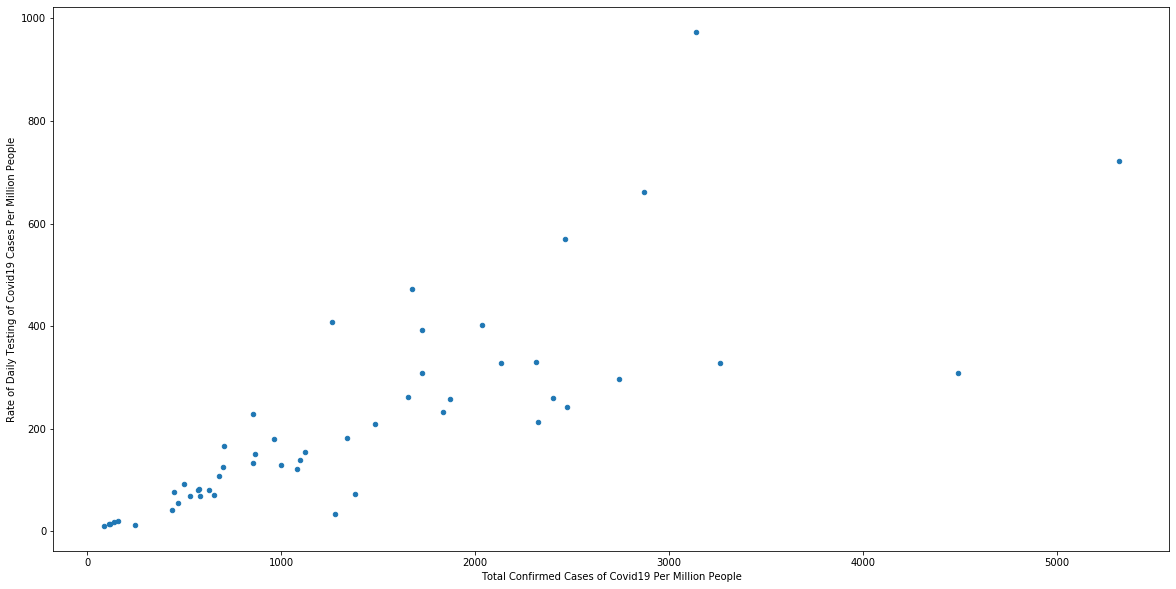

In [35]:
f, ax = plt.subplots(figsize=(20,10))
testing_per_capita.plot.scatter(x='total', y='rolling_test_3d', ax=ax)
ax.set_ylabel("Rate of Daily Testing of Covid19 Cases Per Million People")
ax.set_xlabel("Total Confirmed Cases of Covid19 Per Million People")

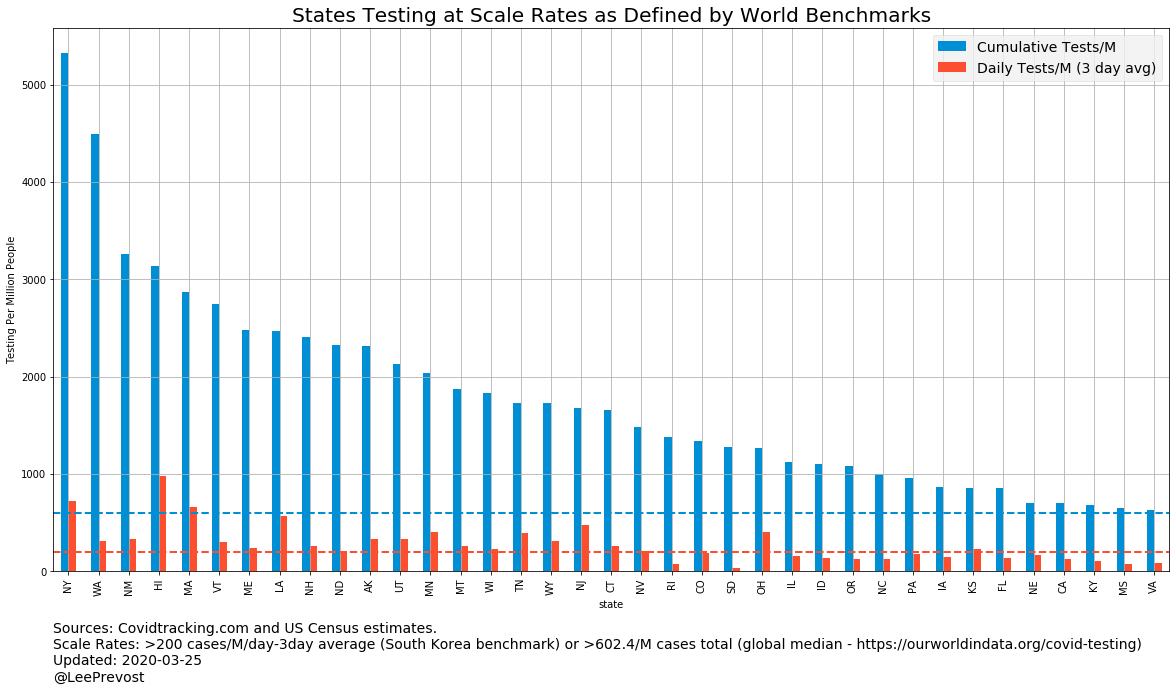

In [36]:
f, ax = plt.subplots(figsize= (20,10))
plt.style.use("fivethirtyeight")
title = "States Testing at Scale Rates as Defined by World Benchmarks"
states_testing_top = testing_per_capita.loc[states_scaling].sort_values(by="total", ascending=False)
ax.set_title(title)
ax.set_ylabel("Testing Per Million People")

label=["Cumulative Tests/M", "Daily Tests/M (3 day avg)"]
states_testing_top.plot(kind='bar', ax=ax, label=label)
colors = colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax.legend(label)
lw=2
ax.axhline(world_tests_cum_median, color = colors[0], linestyle='--', linewidth=lw)
ax.axhline(daily_limit,color=colors[1], linestyle="--", linewidth=lw)
note = """Sources: Covidtracking.com and US Census estimates.
Scale Rates: >200 cases/M/day-3day average (South Korea benchmark) or >602.4/M cases total (global median - https://ourworldindata.org/covid-testing)
Updated: {}
@LeePrevost""".format(daily_last_update)
plt.annotate(note, (0,0), (0, -50), xycoords='axes fraction', textcoords='offset points', va='top')
plt.savefig("{}.jpg".format(title), bbox_inches='tight')

In [37]:

positives = daily_per_capita_M.loc[states_testing_top.index].reset_index().groupby('state').last()['positive']
positives

state
AK      57.412736
CA      53.198728
CO     158.368086
CT     245.422038
FL      78.313651
HI      63.565068
IA      45.957776
ID      40.849102
IL     147.176953
KS      43.249715
KY      35.141336
LA     386.121648
MA     266.666551
ME     110.845611
MN      50.889845
MS     126.673765
MT      49.589344
NC      48.054535
ND      51.176938
NE      31.534195
NH      79.428643
NJ     495.598495
NM      47.691061
NV     104.215501
NY    1583.823137
OH      60.227049
OR      49.552639
PA      88.033195
RI     117.051694
SD      46.345541
TN     114.801585
UT     107.924059
VA      45.808579
VT     197.118859
WA     324.233052
WI     100.473445
WY      76.024736
Name: positive, dtype: float64

In [38]:
positive = daily_per_capita_M.loc[states_testing_top.index].groupby(level=0).last()['positive'].sort_values(ascending=False)
positive_3d_lag = daily_per_capita_M.loc[states_testing_top.index].groupby(level=0).shift(3).groupby(level=0).last()['positive']

In [39]:
positive_3d_lag

state
AK     30.073338
CA     38.874047
CO     82.483378
CT     62.547559
FL     38.644667
HI     33.901370
IA     28.525516
ID     23.502223
IL     83.492341
KS     21.968109
KY     22.159187
LA    180.046696
MA     93.725023
ME     66.209794
MN     29.966494
MS     69.552969
MT     29.005088
NC     24.313306
ND     36.742417
NE     24.813793
NH     47.804276
NJ    215.487397
NM     27.183905
NV     61.685187
NY    779.703007
OH     30.027975
OR     38.172129
PA     37.416061
RI     78.349118
SD     23.737960
TN     73.947450
UT     56.457383
VA     25.657491
VT     83.334802
WA    235.459645
WI     66.123549
WY     41.468038
Name: positive, dtype: float64

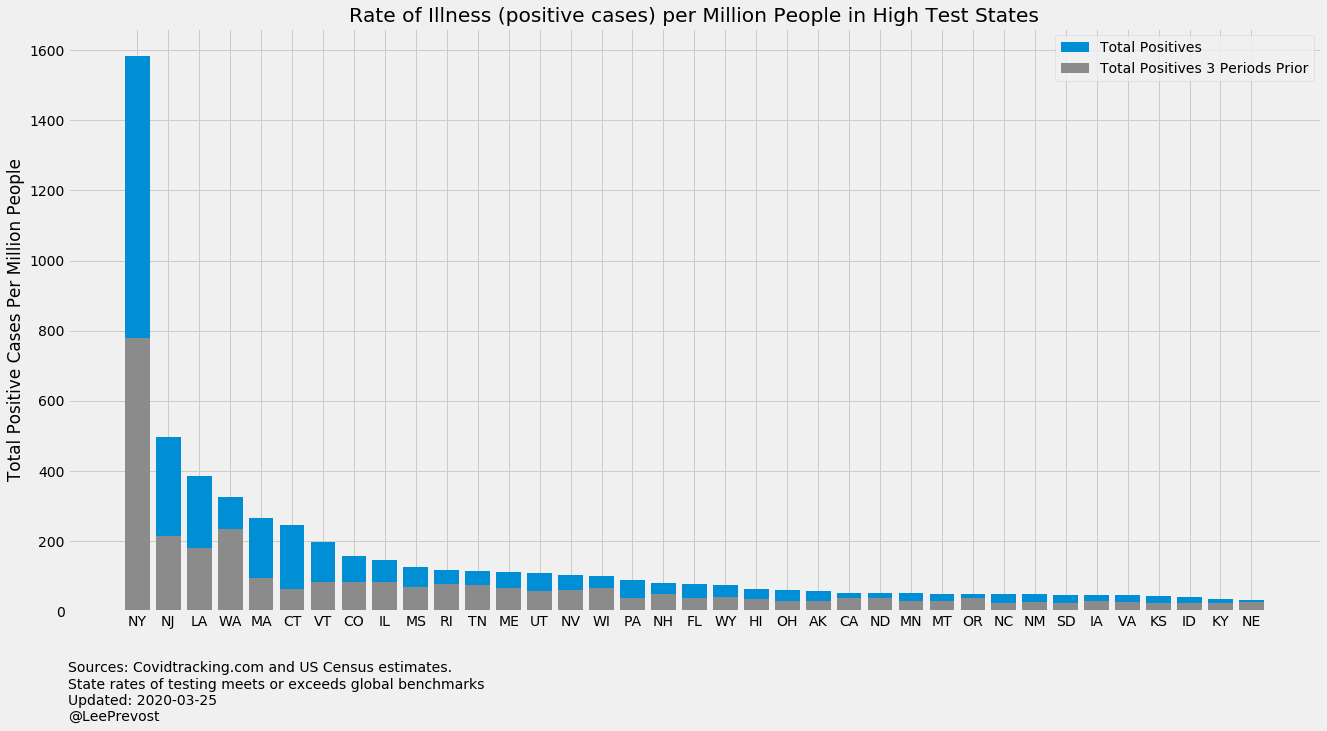

In [40]:
f, ax = plt.subplots(figsize=(20,10))
title = """Rate of Illness (positive cases) per Million People in High Test States"""
ax.bar(positive.index, positive.values)
ax.bar(positive_3d_lag.index, positive_3d_lag.values, color='#8b8b8b')

ax.set_title(title)
ax.set_ylabel("Total Positive Cases Per Million People")
label = ["Total Positives", "Total Positives 3 Periods Prior"]
ax.legend(label)
note = """Sources: Covidtracking.com and US Census estimates.
State rates of testing meets or exceeds global benchmarks
Updated: {}
@LeePrevost""".format(daily_last_update)
plt.annotate(note, (0,0), (0, -50), xycoords='axes fraction', textcoords='offset points', va='top')
plt.savefig("{}.jpg".format(title), bbox_inches='tight')

In [41]:
colors

['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c']

In [44]:
#pull in South Korea data
path = "COVID-19/csse_covid_19_data/csse_covid_19_time_series/"
Confirmed = "time_series_19-covid-Confirmed.csv"
Deaths = "time_series_19-covid-Deaths.csv"
Recovered = "time_series_19-covid-Recovered.csv"
files = {"Confirmed": Confirmed,
        "Deaths": Deaths,
        "Recovered": Recovered}

for k,v in files.items():
    df = pd.read_csv(os.path.join(path, v))
    files.update({k: df})
    
confirmed= files['Confirmed']
deaths = files['Deaths']
recovered = files['Recovered']
confirmed = confirmed[confirmed["Country/Region"].str.contains("Korea")]
deaths = deaths[deaths["Country/Region"].str.contains("Korea")]
recovered = recovered[recovered["Country/Region"].str.contains("Korea")]
sit_report = pd.concat([confirmed, deaths, recovered], keys = files.keys())
sit_report = sit_report.reset_index().set_index(["Country/Region", 'level_0']).iloc[:, 4:].T
sit_report.index.name = "Day"
ndx = pd.to_datetime(sit_report.index)
sit_report = sit_report.set_index(ndx)

In [53]:
sit_report

Country/Region Korea, South                   population
level_0           Confirmed Deaths Recovered            
Day                                                     
2020-01-22              1.0    0.0       0.0  51500000.0
2020-01-23              1.0    0.0       0.0  51500000.0
2020-01-24              2.0    0.0       0.0  51500000.0
2020-01-25              2.0    0.0       0.0  51500000.0
2020-01-26              3.0    0.0       0.0  51500000.0
...                     ...    ...       ...         ...
2020-03-19           8565.0   91.0    1540.0  51500000.0
2020-03-20           8652.0   94.0    1540.0  51500000.0
2020-03-21           8799.0  102.0    1540.0  51500000.0
2020-03-22           8897.0  104.0    2909.0  51500000.0
2020-03-23           8897.0  104.0    2909.0  51500000.0

[62 rows x 4 columns]

In [45]:
date_start = pd.datetime(2020, 3, 4)   #allows global data to synch with start of US data

In [46]:
confirmed = files['Confirmed']
italy = confirmed[confirmed["Country/Region"].str.contains("Italy")].set_index("Country/Region", drop=True).iloc[:,4:].T
italy.index.name="Day"

italy.name = "Italy"
ndx = pd.to_datetime(italy.index)
italy = italy.set_index(ndx)
italy_pop = italy*1e6/60.5e6
italy_pop = italy_pop.loc[italy_pop.index >= date_start]

In [47]:
italy

Country/Region,Italy
Day,
2020-01-23,0.0
2020-01-24,0.0
2020-01-25,0.0
2020-01-26,0.0
2020-01-27,0.0
...,...
2020-03-19,41035.0
2020-03-20,47021.0
2020-03-21,53578.0


In [48]:
sit_report['population']=51.5e6
sit_report.index

DatetimeIndex(['2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25',
               '2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29',
               '2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02',
               '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06',
               '2020-02-07', '2020-02-08', '2020-02-09', '2020-02-10',
               '2020-02-11', '2020-02-12', '2020-02-13', '2020-02-14',
               '2020-02-15', '2020-02-16', '2020-02-17', '2020-02-18',
               '2020-02-19', '2020-02-20', '2020-02-21', '2020-02-22',
               '2020-02-23', '2020-02-24', '2020-02-25', '2020-02-26',
               '2020-02-27', '2020-02-28', '2020-02-29', '2020-03-01',
               '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05',
               '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09',
               '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13',
               '2020-03-14', '2020-03-15', '2020-03-16', '2020-03-17',
      

In [49]:
sk_confirmed = sit_report.T.reset_index(0, drop=True).T[['Confirmed', 'Deaths', 'Recovered']].div(sit_report.iloc[:, 3]/1e6, axis=0)['Confirmed']
sk_confirmed = sk_confirmed.to_frame()

In [50]:
sk_confirmed.columns = ["South Korea"]
#limit to US dates
sk_confirmed = sk_confirmed.loc[sk_confirmed.index>= date_start]
sk_confirmed

,South Korea
Day,
2020-03-04,109.145631
2020-03-05,118.213592
2020-03-06,128.019417
2020-03-07,136.718447
2020-03-08,142.019417
2020-03-09,145.203883
2020-03-10,145.883495
2020-03-11,150.582524
2020-03-12,152.796117


In [51]:
daily_per_capita_M.replace(0,pd.np.nan)

positive     negative    pending  death        total  \
state date                                                                
AK    2020-03-06        NaN    10.935759   1.366970    NaN    12.302729   
      2020-03-07        NaN    16.403639   2.733940    NaN    19.137579   
      2020-03-08        NaN    19.137579   8.201819    NaN    27.339398   
      2020-03-09        NaN    31.440308  12.302729    NaN    43.743037   
      2020-03-10        NaN    31.440308  12.302729    NaN    43.743037   
...                     ...          ...        ...    ...          ...   
WY    2020-03-21  39.740203   756.791687        NaN    NaN   796.531890   
      2020-03-22  41.468038   756.791687        NaN    NaN   798.259725   
      2020-03-23  44.923707  1022.878262        NaN    NaN  1067.801969   
      2020-03-24  50.107212  1226.762780        NaN    NaN  1276.869993   
      2020-03-25  76.024736  1648.354496        NaN    NaN  1724.379232   

                  daily_test  rolling_test_3d   bool  test_scale_ndx  
state date                                                            
AK    2020-03-06         NaN              NaN  False             NaN  
      2020-03-07    6.834850              NaN  False             NaN  
      2020-03-08    8.201819              NaN  False             NaN  
      2020-03-09   16.403639        10.480103  False             NaN  
      2020-03-10         NaN         8.201819  False             NaN  
...                      ...              ...    ...             ...  
WY    2020-03-21  191.789674       154.353251   True             1.0  
      2020-03-22    1.727835        99.638479   True             2.0  
      2020-03-23  269.542245       154.353251   True             3.0  
      2020-03-24  209.068023       160.112701   True             4.0  
      2020-03-25  447.509240       308.706502   True             5.0  

[1032 rows x 9 columns]

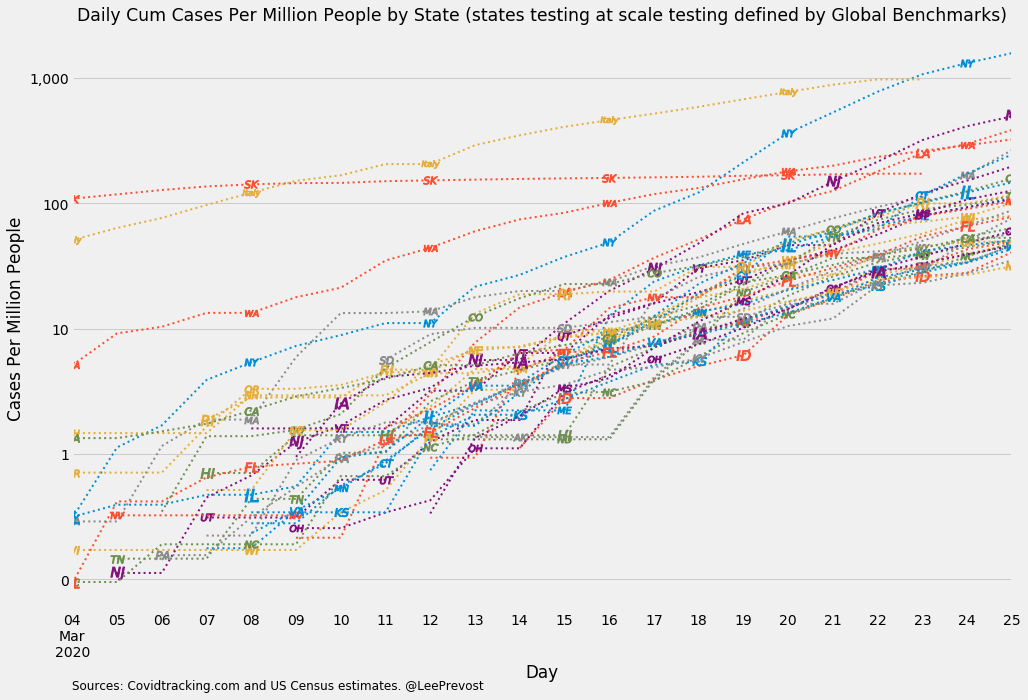

In [52]:

f, ax = plt.subplots(figsize=(15,10))
plt.rcParams.update({"font.size": 12})
#plt.style.use("seaborn")
lines = dict(legend=False, markersize=14, ax=ax, linewidth=2, markevery=4, logy=True, linestyle='dotted')

for ndx, state in enumerate(states_testing_top.index):
    daily_per_capita_M.replace(0, pd.np.nan).loc[states_testing_top.index[ndx]]['positive'].\
        plot(label=state, marker='${}$'.format(state), **lines)
    
sk_confirmed.plot(label="South Korea", marker='$SK$', **lines)
lines.pop("markersize")
italy_pop.plot(label="Italy", marker='$Italy$', markersize=18, **lines)
ax.set_ylabel("Cases Per Million People")
note = """Sources: Covidtracking.com and US Census estimates. @LeePrevost"""
plt.annotate(note, (0,0), (0, -70), xycoords='axes fraction', textcoords='offset points', va='top')
title = "Daily Cum Cases Per Million People by State (states testing at scale testing defined by Global Benchmarks)"
plt.title(title)
ax.get_yaxis().set_major_formatter(
    tick.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.savefig("{}.jpg".format(title), bbox_inches='tight')